# Analysis

This notebook is the primary analysis notebook for tau_map6 simulations. This is loosely based off `first_analysis.ipynb` with additional functionality from `data_process_funcs.py`.

## Notebook Configuration

In [2]:
# import packages
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colormaps

from rich import print
from tqdm import tqdm

In [3]:
# import functions
from data_process_funcs import *

In [4]:
# configure plotting
# define the figure save directory
figure_dir = Path("figures")
os.makedirs(figure_dir, exist_ok=True)

# set plot style
cstyle_file_url = r"https://gist.githubusercontent.com/CalvinSprouse/30bba681da1dd0023e948ca207fad0fc/raw/80a1ae94031873a57c9624103e83f5caf175ac86/cstyle.mplstyle"
plt.style.use(["default", cstyle_file_url])

## Define Functions

In [5]:
# define a function to make a grouped bar plot
def grouped_bar_plot(fig, ax,
                     group_data: dict,
                     group_labels: list,
                     colors: list = None,
                     bar_width: float = 0.2,
                     multiplier: float = 0,
                     **kwargs):
    """Plots a grouped bar plot

    Arguments:
        fig -- _description_
        ax -- _description_
        group_data -- _description_

    Keyword Arguments:
        colors -- _description_ (default: {None})
        bar_width -- _description_ (default: {0.2})
        multiplier -- _description_ (default: {0})

    Raises:
        ValueError: _description_

    Returns:
        _description_
    """

    # extract groups from keys of group_data
    group_count = len(group_labels)

    # the default value of colors should be a built in color list
    if colors is None:
        colors = colormaps["tab10"].colors
    else:
        # check if the length of colors is greater than the number of groups
        if len(colors) < group_count:
            raise ValueError("The number of colors provided is less than the number of groups")

    # define the label locations
    x_locations = np.arange(group_count)

    # plot the bars
    for index, attr_meas in enumerate(group_data.items()):
        # unpack attr_meas
        attribute = attr_meas[0]
        measurement = attr_meas[1]

        # calculate the offset location of each bar
        offset = bar_width * multiplier

        # draw the bar and insert kwargs
        ax.bar(
            x_locations + offset,
            measurement,
            bar_width,
            label=attribute,
            color=colors[index],
            **kwargs
        )

        # iterate the multiplier to space the next bar
        multiplier += 1

    # set the x ticks
    ax.set_xticks(x_locations + bar_width, group_labels)

    return fig, ax

## Import Data

In [6]:
# define the data directory
data_dir = Path("raw_sim_data")

# get the .mat files from data_dir
mat_files = list(data_dir.glob("*.mat"))

In [7]:
# define a list of variables to extract from mat_files
value_list = ["T0", "M0", "taufractip", "taufraclength", "tauplusendasym", "mapfractip", "mapfraclength", "mapplusendasym", "L", "save_str", "MTlength", "MTgrid", "x", "t"]

# convert mat files to sim_dict and sim_df
sim_dict = extract_sim_dict(mat_files, value_list)
sim_df = create_sim_df(sim_dict)

## Process Data

In [8]:
# calculate new column values
# calculate T0/M0
sim_df["T0/M0"] = sim_df["T0"] / sim_df["M0"]

In [9]:
# create an average df indexed by T0/M0
sim_avg_df = sim_df.groupby("T0/M0").mean()

## Plotting of Averages DF

### Binding Rate Ratio vs. MT Length

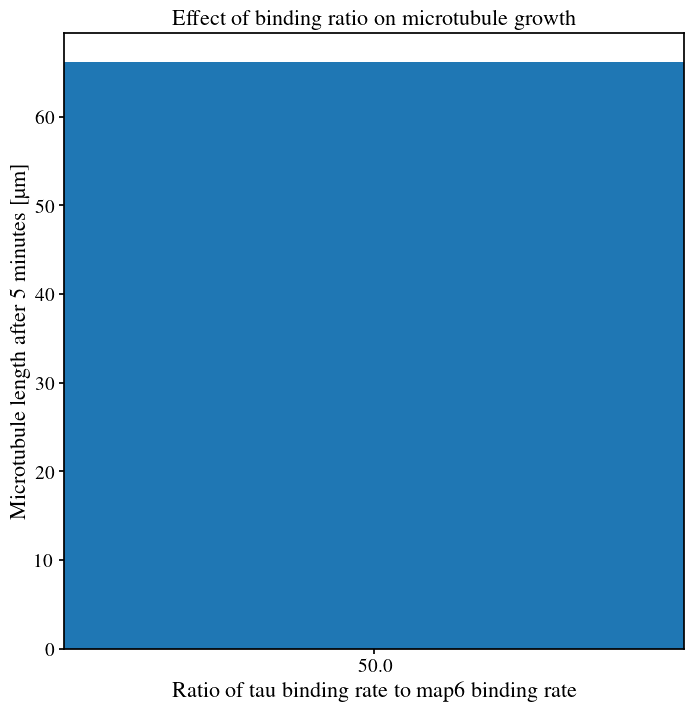

In [10]:
# define the grouped data and group labels
group_data = {"L": sim_avg_df["L"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the grouped bar plot
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Microtubule length after 5 minutes [$\qty{}{\micro\meter}$]")
ax.set_title(r"Effect of binding ratio on microtubule growth")

# save the figure
fig.savefig(figure_dir / r"growth_effect")

### Binding Asymmetry

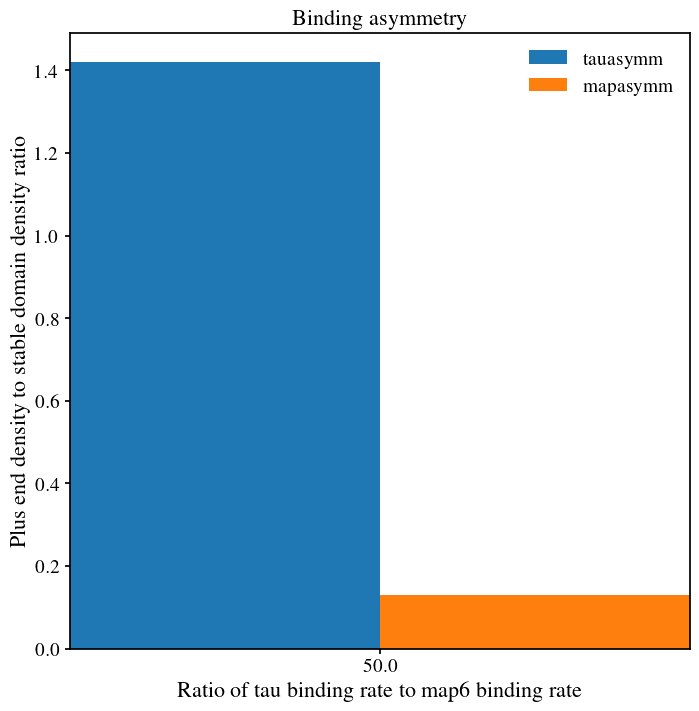

In [11]:
# make a grouped bar plot of binding asymmetry
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. tau plus end density to stable domain density ratio (tauasymm)
# 2. map6 plus end density to stable domain density ratio (mapasymm)

# define the group data and group labels
group_data = {"tauasymm": sim_avg_df["tauplusendasym"], "mapasymm": sim_avg_df["mapplusendasym"]}
group_labels = sim_avg_df.index

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=1/2)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate")
ax.set_ylabel(r"Plus end density to stable domain density ratio")
ax.set_title(r"Binding asymmetry")

# set the legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"asymm_effect")

### Distribution Dependence on Tau On-Rate

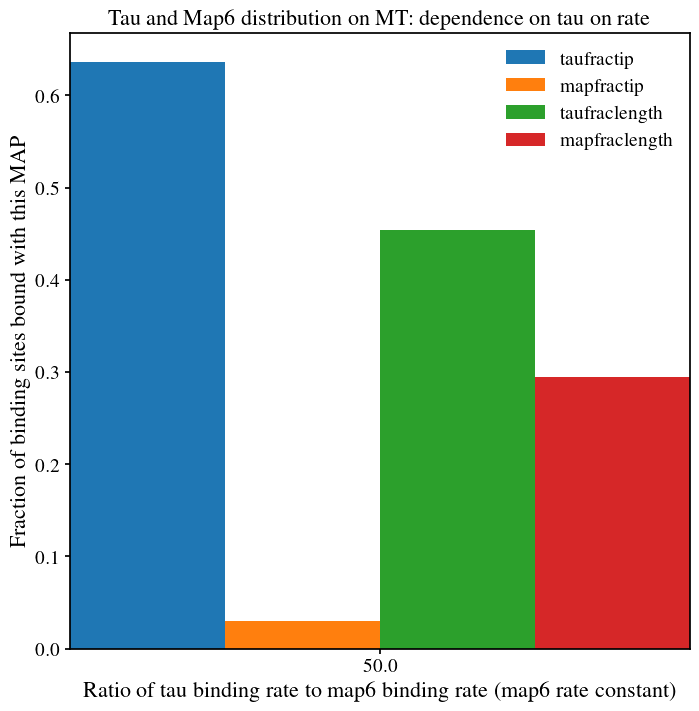

In [12]:
# make a grouped bar plot
# on the horizontal: ratio of tau binding rate to map6 binding rate
# on the vertical:
# 1. plus-end tau fraction (taufractip)
# 2. plus-end map6 fraction (mapfractip)
# 3. stable domain tau fraction (taufraclength)
# 4. stable domain map6 fraction (mapfraclength)

# define the group data and group labels (T0/M0)
group_data = {
    "taufractip": sim_avg_df["taufractip"],
    "mapfractip": sim_avg_df["mapfractip"],
    "taufraclength": sim_avg_df["taufraclength"],
    "mapfraclength": sim_avg_df["mapfraclength"],
}
group_labels = sim_avg_df.index

# define the colors
colors = ["orange", "blue", "grey", "green"]

# define the figure
fig, ax = plt.subplots()

# plot the data
fig, ax = grouped_bar_plot(fig, ax, group_data, group_labels, multiplier=-1/2)

# set the labels
ax.set_xlabel(r"Ratio of tau binding rate to map6 binding rate (map6 rate constant)")
ax.set_ylabel(r"Fraction of binding sites bound with this MAP")
ax.set_title(r"Tau and Map6 distribution on MT: dependence on tau on rate")

# add a legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"binding_distribution_grouped")

## Plotting Individual Simulations

### Plot MT Length Over Time

#### Plot

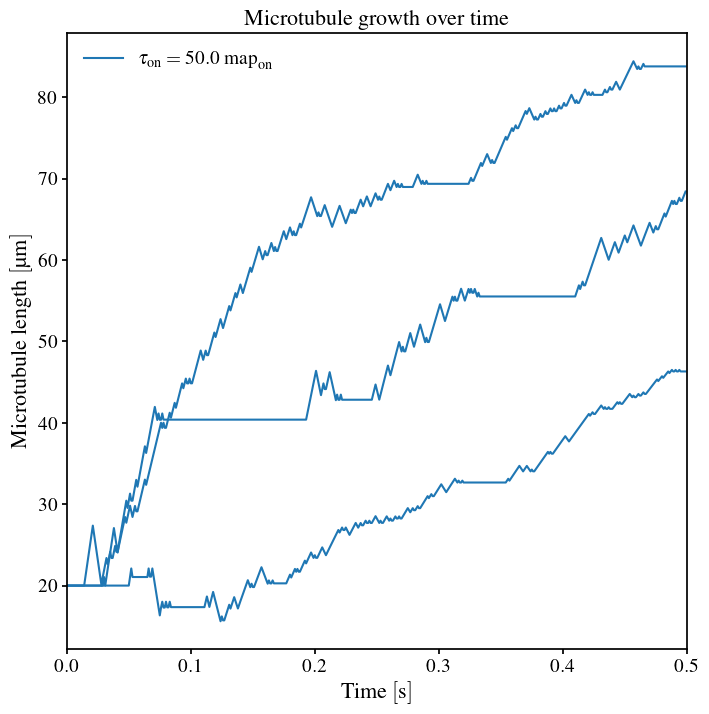

In [16]:
# plot the length of the microtube over time
# define the figure
fig, ax = plt.subplots()

# get a list of colors to iterate over
colors = list(colormaps["tab10"].colors)

# define a dictionary to color similar tau_ratios
tau_ratio_dict = {}

# iterate over each simulation in sim_dict and get the time and length array
for sim_name in sim_dict.keys():
    # get the arrays
    mt_length_array = sim_dict[sim_name]["MTlength"]
    length_list = mt_length_array[:, 1]
    time_list = mt_length_array[:, 0]

    # get the tau binding rate T0 ratio
    tau_ratio = sim_df["T0/M0"][sim_name]

    # define the label
    label = r"$\tau_{\text{on}}=" + f"{tau_ratio}" + r"\ \text{map}_\text{on}$"

    # get a unique color for each tau ratio
    # if the color has been used, make the label None
    if tau_ratio not in tau_ratio_dict.keys():
        tau_ratio_dict[tau_ratio] = colors.pop(0)
    else:
        label = None

    # plot the length over time for this mt
    ax.plot(
        time_list,
        length_list,
        label=label,
        color=tau_ratio_dict[tau_ratio]
    )

# set the axis limits
# the x limit should be the final time plus the second time
# this has the effect of showing an "even" value
ax.set_xlim(0, time_list[-1] + time_list[1])

# set the labels
ax.set_xlabel(r"Time $\left[\qty{}{\second}\right]$")
ax.set_ylabel(r"Microtubule length $\left[\qty{}{\micro\meter}\right]$")
ax.set_title(r"Microtubule growth over time")

# add a legend
ax.legend()

# save the figure
fig.savefig(figure_dir / r"mt_growth_over_time")

### Plot map6 Distribution

#### Plot

In [ ]:
# plot the map6 distribution along an MT
# define the figure
fig, ax = plt.subplots()
